# Protein Analysis and Clustering

This notebook demonstrates how to compute protein features from amino acid sequences using Biopython, then cluster proteins based on these features. The approach is analogous to the glycan analysis you described, but here we work with sequence-based descriptors.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

# Ensure inline plots
%matplotlib inline

proteins = pd.read_csv('../data/Protein-Sequence-Table.txt', sep='\t')
proteins.head()

,ProteinGroup,Accession,Uniprot,Description,Amino Acid Sequence
0,1,Q41358,SNAIB_SAMNI,Ribosome-inactivating protein SNAI,MRLVAKLLYLAVLAICGLGIHGALTHPRVTPPVYPSVSFNLTGADT...
1,2,P22972,LEC1_ULEEU,Anti-H(O) lectin 1,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...
2,4,A8WDZ4,A8WDZ4_CANEN,Concanavalin A,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...
3,6,P09382,LEG1_HUMAN,Galectin-1,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...
4,7,P16045,LEG1_MOUSE,Galectin-1,MACGLVASNLNLKPGECLKVRGEVASDAKSFVLNLGKDSNNLCLHF...


### Glycan–Protein Interaction Feature Extraction

This function extracts features that capture key dimensions of protein sequences relevant to glycan binding. It includes:

- **Overall size and stability**: Length, molecular weight, and instability index.  
- **Charge properties**: Isoelectric point and net charge at pH 7, essential for electrostatic interactions with charged glycans.  
- **Polar/hydrogen-bonding residues**: Fractions of N, Q, S, T, K, R, D, E—critical for forming hydrogen bonds with sugar groups.  
- **Aromatic residues**: Fractions of F, Y, W, plus an aromatic binding score that sums these fractions, reflecting the potential for CH–π interactions.  
- **Hydrophobicity**: An average Kyte-Doolittle score to show how hydrophobic or hydrophilic the sequence is overall.

Together, these features capture multiple facets—charge, polar binding potential, aromatic stacking ability, and structural characteristics—giving us a broad view of each protein’s capacity for glycan interaction.

In [4]:
def compute_protein_features(seq):

    # Add reasoning for feature vectors
    
    # Protein Analysis is a Tool from Biopython
    analysis = ProteinAnalysis(seq)
    features = {}
    
    # The following are Basic Features
    features['length'] = len(seq)
    features['mw'] = analysis.molecular_weight()
    features['instability_index'] = analysis.instability_index()

    features['net_charge_pH7'] = analysis.charge_at_pH(7.0)

    aa_percent = analysis.get_amino_acids_percent()

    # Prompted ChatGPT to ask how to parse a
    # N, Q, S, T: Polar Amino Acids, often involved in hydrogen bonding with glycans
    # K, R: Basic Amino Acids, can form hydrogen bonds and electrostatic bonds
    # D, E: Acidic Amino Acids, can interact with positively charged groups of glycans
    for aa in ['N', 'Q', 'S', 'T', 'K', 'R', 'D', 'E']:
        features[f'frac_{aa}'] = aa_percent.get(aa, 0.0)

   
   # F, Y, W are aromatic amino acids which bind with glycans
    for aa in ['F', 'Y', 'W']:
        features[f'frac_{aa}'] = aa_percent.get(aa, 0.0)
        features['aromatic_binding_score'] = (
        aa_percent.get('F', 0.0) +
        aa_percent.get('Y', 0.0) +
        aa_percent.get('W', 0.0)
    )

    features['aromaticity'] = analysis.aromaticity()

    features['hydrophobicity'] = analysis.gravy()

    return features

# Prompted ChatGPT how to parse the result of compute protein features
feature_dicts = proteins['Amino Acid Sequence'].apply(compute_protein_features)
features_df = pd.DataFrame(list(feature_dicts))

proteins = pd.concat([proteins, features_df], axis=1)

# Display the updated dataframe
proteins.head()

/opt/miniconda3/envs/test_env/lib/python3.12/site-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


,ProteinGroup,Accession,Uniprot,Description,Amino Acid Sequence,length,mw,instability_index,net_charge_pH7,frac_N,...,frac_K,frac_R,frac_D,frac_E,frac_F,aromatic_binding_score,frac_Y,frac_W,aromaticity,hydrophobicity
0,1,Q41358,SNAIB_SAMNI,Ribosome-inactivating protein SNAI,MRLVAKLLYLAVLAICGLGIHGALTHPRVTPPVYPSVSFNLTGADT...,570,63100.9796,30.327544,-8.842719,0.064912,...,0.022807,0.057895,0.045614,0.050877,0.035088,0.085965,0.033333,0.017544,0.085965,-0.069298
1,2,P22972,LEC1_ULEEU,Anti-H(O) lectin 1,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...,243,26669.1822,33.731687,-11.254626,0.082305,...,0.041152,0.028807,0.065844,0.049383,0.069959,0.119342,0.032922,0.016461,0.119342,-0.239095
2,4,A8WDZ4,A8WDZ4_CANEN,Concanavalin A,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...,290,31480.0500,31.053483,-5.954748,0.062069,...,0.051724,0.024138,0.068966,0.027586,0.055172,0.096552,0.027586,0.013793,0.096552,-0.020690
3,6,P09382,LEG1_HUMAN,Galectin-1,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...,135,14715.5455,24.134815,-3.361802,0.096296,...,0.059259,0.037037,0.066667,0.051852,0.074074,0.096296,0.014815,0.007407,0.096296,-0.151111
4,7,P16045,LEG1_MOUSE,Galectin-1,MACGLVASNLNLKPGECLKVRGEVASDAKSFVLNLGKDSNNLCLHF...,135,14865.6989,20.876296,-5.179766,0.088889,...,0.066667,0.029630,0.066667,0.066667,0.074074,0.088889,0.007407,0.007407,0.088889,-0.264444


## Clustering Proteins Based on Features

Using the computed features, we calculate a pairwise Euclidean distance matrix and apply KMeans clustering to group similar proteins together. This step will help us later perform train/test splits that respect protein similarity.

In [5]:
# Select the feature columns (all columns from the feature extraction)
feature_columns = features_df.columns.tolist()
feature_data = proteins[feature_columns].values

# apply k means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
proteins['cluster_label'] = kmeans.fit_predict(feature_data)

# Show cluster counts
print(proteins['cluster_label'].value_counts())

cluster_label
1    26
0    21
2     5
Name: count, dtype: int64


## Visualize Clusters with PCA

We use PCA to reduce the feature space to 2 dimensions for visualization. This helps in understanding how the proteins are grouped based on the computed descriptors.

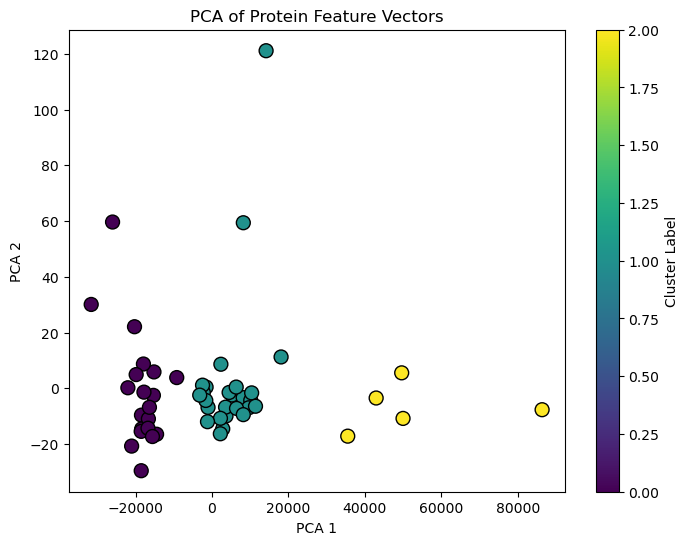

In [6]:
# Perform PCA to reduce the feature dimensionality
pca = PCA(n_components=2)
pca_components = pca.fit_transform(feature_data)

plt.figure(figsize=(8, 6))
# Visualize protein clusters in 2D PCA space: x=PCA1, y=PCA2, colors=clusters, 
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], 
                      c=proteins['cluster_label'], cmap='viridis', s=100, edgecolor='k')
plt.title('PCA of Protein Feature Vectors')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

- Assign entire clusters to either train or test
- Ensure proteins that are similar remain in the same cluster

In [6]:
unique_clusters = proteins['cluster_label'].unique()
np.random.seed(42)
np.random.shuffle(unique_clusters)

test_fraction = 0.01
n_test_clusters = max(1, int(len(unique_clusters) * test_fraction))
test_clusters = unique_clusters[:n_test_clusters]
train_clusters = unique_clusters[n_test_clusters:]

print(f"Test clusters: {test_clusters}")
print(f"Train clusters: {train_clusters}")

train_set = proteins[proteins['cluster_label'].isin(train_clusters)].copy()
test_set = proteins[proteins['cluster_label'].isin(test_clusters)].copy()

print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Test clusters: [2]
Train clusters: [1 0]
Train set size: 47
Test set size: 5


In [7]:
# Group proteins by cluster and compute statistics for each feature
def analyze_clusters(proteins_df, feature_columns):
    """
    Analyze differences between clusters based on feature values.
    
    Parameters:
    proteins_df: DataFrame containing protein data with cluster_label column
    feature_columns: List of feature columns to analyze
    
    Returns:
    Formatted summary statistics for each cluster
    """
    # Create a comprehensive summary for all relevant features
    cluster_summary = {}
    
    for feature in feature_columns:
        # Group by cluster and calculate statistics
        stats = proteins_df.groupby('cluster_label')[feature].agg(['mean', 'std', 'min', 'max'])
        cluster_summary[feature] = stats
    
    # Convert to a more readable format
    formatted_summary = pd.concat(cluster_summary.values(), keys=cluster_summary.keys(), axis=1)
    
    return formatted_summary

# Select important features for analysis
important_features = [
    'length', 'mw', 'instability_index', 'net_charge_pH7',
    'frac_N', 'frac_Q', 'frac_S', 'frac_T',  # Polar amino acids
    'frac_K', 'frac_R',  # Basic amino acids
    'frac_D', 'frac_E',  # Acidic amino acids
    'frac_F', 'frac_Y', 'frac_W',  # Aromatic amino acids
    'aromatic_binding_score', 'aromaticity', 'hydrophobicity'
]

# Generate the cluster comparison
cluster_comparison = analyze_clusters(proteins, important_features)
print(cluster_comparison)

# For a cleaner view focused on means (averages)
means_by_cluster = pd.DataFrame({
    feature: proteins.groupby('cluster_label')[feature].mean() 
    for feature in important_features
})
print("\nMean values for each feature by cluster:\n")
print(means_by_cluster.round(4))

# Create a heatmap to visualize the differences
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Normalize the values to make them comparable
normalized_means = means_by_cluster.copy()
for col in normalized_means.columns:
    # Min-max normalization
    min_val = normalized_means[col].min()
    max_val = normalized_means[col].max()
    if max_val > min_val:  # Avoid division by zero
        normalized_means[col] = (normalized_means[col] - min_val) / (max_val - min_val)

# Plot heatmap
sns.heatmap(normalized_means, annot=means_by_cluster.round(3), fmt='.3f', 
            cmap='viridis', linewidths=.5)
plt.title('Feature Comparison Across Clusters')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

# Create boxplots for key discriminating features
key_features = ['length', 'aromatic_binding_score', 'hydrophobicity', 'net_charge_pH7']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(x='cluster_label', y=feature, data=proteins, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Cluster')
    axes[i].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

                   length                                                     \
                   length                                                      
                     mean         std  min  max        mean         std  min   
cluster_label                                                                  
0              134.857143   30.893827   46  212  134.857143   30.893827   46   
1              285.884615   36.215275  234  372  285.884615   36.215275  234   
2              582.400000  121.096243  471  787  582.400000  121.096243  471   

                              mw                ... aromaticity            \
                              mw                ... aromaticity             
               max          mean           std  ...         min       max   
cluster_label                                   ...                         
0              212  14689.401148   3143.708114  ...    0.060403  0.165414   
1              372  31136.728154   3934.181962  ...   

ValueError: If using all scalar values, you must pass an index